# Seq2Seq and Attention

In [1]:
import os
import pandas as pd
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from torch.nn.utils.rnn import (
    pad_sequence,
    pack_padded_sequence,
    pad_packed_sequence,
)
from tokenizers import (
    Tokenizer,
    normalizers,
    pre_tokenizers,
    models,
    processors,
    trainers,
)
from sklearn.model_selection import train_test_split
from torchmetrics.classification import MulticlassAccuracy
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    TQDMProgressBar,
)
from pytorch_lightning.loggers import CSVLogger
from typing import Literal
from tqdm import tqdm

/home/misha/.pyenv/versions/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Датасет

Ниже скачивание `rus_eng.txt` файла с google drive. Каждая строка - это пара `русское_предложение[SEP]предложение_на_английском`. Сами предложения взяты из [tatoeba.org](https://tatoeba.org/en/downloads). Получение выборки можно посмотреть [здесь](08*.Preprocess.ipynb)

In [2]:
!gdown -c "https://drive.google.com/uc?id=10y6di8hDNzLvmvrHRj2iCo5GxFSxbGLH"

Skipping already downloaded file rus_eng.txt


In [3]:
with open("rus_eng.txt", "r", encoding="utf-8") as file:
    pairs = [line.strip() for line in file]

In [4]:
pairs[:3]

['Как патетично![SEP]How pathetic!',
 "Теперь ты мужчина.[SEP]You're a man now.",
 'Том повторил то, что он только что сказал.[SEP]Tom repeated what he had just said.']

In [5]:
len(pairs)

100000

## Train-Validation-Test Split

In [6]:
# Сначала разделяем на train и временный (val+test)
train_pairs, temp_pairs = train_test_split(
    pairs, test_size=0.3, random_state=42
)

# Затем временный разделяем на val и test
val_pairs, test_pairs = train_test_split(
    temp_pairs, test_size=0.5, random_state=42
)

In [7]:
print(f"train_size: {len(train_pairs)}")
print(f"val_size: {len(val_pairs)}")
print(f"test_size: {len(test_pairs)}")

train_size: 70000
val_size: 15000
test_size: 15000


## Токенизация

- Разделим на `input` и `target`, используя разделитель `[SEQ]`;
- Начало предложения пометим `[BOS]`;
- Конец - `[EOS]`;
- Обучим `word-level` токенизатор;

In [8]:
SPECIAL_TOKENS = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]

In [9]:
def separate(pair: str, separator: str = "[SEP]") -> list[str, str]:
    return pair.split(separator)


train_rus_sentences, train_eng_sentences = zip(
    *(separate(pair) for pair in train_pairs)
)
val_rus_sentences, val_eng_sentences = zip(
    *(separate(pair) for pair in val_pairs)
)
test_rus_sentences, test_eng_sentences = zip(
    *(separate(pair) for pair in test_pairs)
)

In [10]:
def create_tokenizer(lang: Literal["eng", "rus"]):
    if lang == "eng":
        normalizers_lst = [
            normalizers.NFD(),
            normalizers.StripAccents(),
            normalizers.Lowercase(),
        ]
    elif lang == "rus":
        normalizers_lst = [
            normalizers.NFD(),
            normalizers.Lowercase(),
        ]
    else:
        raise Exception(f"Unknown language '{lang}'")

    tokenizer = Tokenizer(model=models.WordLevel(unk_token="[UNK]"))
    tokenizer.normalizer = normalizers.Sequence(normalizers_lst)
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer.post_processor = processors.TemplateProcessing(
        single="[BOS] $A [EOS]",
        pair="[BOS] $A $B [EOS]",
        special_tokens=[
            ("[BOS]", SPECIAL_TOKENS.index("[BOS]")),
            ("[EOS]", SPECIAL_TOKENS.index("[EOS]")),
        ],
    )
    return tokenizer


def disable_tokenizers_parallelism():
    os.environ["TOKENIZERS_PARALLELISM"] = "false"


def enable_tokenizers_parallelism():
    os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [11]:
rus_tokenizer = create_tokenizer(lang="rus")
eng_tokenizer = create_tokenizer(lang="eng")

In [12]:
tokenizer_trainer = trainers.WordLevelTrainer(special_tokens=SPECIAL_TOKENS)

In [13]:
rus_tokenizer.train_from_iterator(train_rus_sentences, tokenizer_trainer)
eng_tokenizer.train_from_iterator(train_eng_sentences, tokenizer_trainer)

## Dataset-ы и DataLoader-ы

In [14]:
class TranslationDataset(data.Dataset):
    def __init__(
        self,
        rus_sentences: list[str],
        eng_sentences: list[str],
        rus_tokenizer: Tokenizer,
        eng_tokenizer: Tokenizer,
    ):
        super().__init__()
        self.rus_tokenizer = rus_tokenizer
        self.eng_tokenizer = eng_tokenizer

        self.encoder_inputs = [
            torch.tensor(sentence.ids, dtype=torch.long)
            for sentence in rus_tokenizer.encode_batch(rus_sentences)
        ]

        decoder_temp = [
            sentence.ids
            for sentence in eng_tokenizer.encode_batch(eng_sentences)
        ]
        # Убираем [EOS]
        self.decoder_inputs = [
            torch.tensor(sentence[:-1], dtype=torch.long)
            for sentence in decoder_temp
        ]
        # Убираем [BOS]
        self.decoder_targets = [
            torch.tensor(sentence[1:], dtype=torch.long)
            for sentence in decoder_temp
        ]

        self.size = len(self.encoder_inputs)

    def __getitem__(
        self, index
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]: encoder_inputs, decoder_inputs, decoder_targets
        """
        return (
            self.encoder_inputs[index],
            self.decoder_inputs[index],
            self.decoder_targets[index],
        )

    def __len__(self):
        return self.size

In [15]:
class DataCollator:
    def __init__(self, pad_idx: int = 0):
        self.pad_idx = pad_idx

    def __call__(self, batch: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        """
        Returns:
            tuple[torch.Tensor]: encoder_inputs_padded, encoder_inputs_lengths, decoder_inputs_padded, decoder_inputs_lengths, decoder_targets_padded,
        """
        encoder_inputs, decoder_inputs, decoder_targets = zip(*batch)

        encoder_inputs_lengths = torch.tensor(
            [len(seq) for seq in encoder_inputs], dtype=torch.long
        )
        decoder_inputs_lengths = torch.tensor(
            [len(seq) for seq in decoder_inputs], dtype=torch.long
        )

        encoder_inputs_padded = pad_sequence(
            encoder_inputs,
            batch_first=True,
            padding_value=self.pad_idx,
            padding_side="right",
        )
        decoder_inputs_padded = pad_sequence(
            decoder_inputs,
            batch_first=True,
            padding_value=self.pad_idx,
            padding_side="right",
        )
        decoder_targets_padded = pad_sequence(
            decoder_targets,
            batch_first=True,
            padding_value=self.pad_idx,
            padding_side="right",
        )

        return (
            encoder_inputs_padded,
            encoder_inputs_lengths,
            decoder_inputs_padded,
            decoder_inputs_lengths,
            decoder_targets_padded,
        )

In [16]:
BATCH_SIZE = 16

collator = DataCollator(pad_idx=rus_tokenizer.token_to_id("[PAD]"))

train_dataset = TranslationDataset(
    train_rus_sentences, train_eng_sentences, rus_tokenizer, eng_tokenizer
)
val_dataset = TranslationDataset(
    val_rus_sentences, val_eng_sentences, rus_tokenizer, eng_tokenizer
)
test_dataset = TranslationDataset(
    test_rus_sentences, test_eng_sentences, rus_tokenizer, eng_tokenizer
)

train_dataloader = data.DataLoader(
    train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collator, num_workers=2
)
val_dataloader = data.DataLoader(
    val_dataset, BATCH_SIZE, shuffle=False, collate_fn=collator, num_workers=2
)
test_dataloader = data.DataLoader(
    test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collator, num_workers=2
)

## Машинный перевод seq2seq without attention

Модель будет использовать два LSTM сети (энкодер и декодер) для перевода с русского языка на английский.

### Модель

In [17]:
class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        padding_idx: int,
        hidden_size: int,
    ):
        super().__init__()
        self.padding_idx = padding_idx
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=padding_idx
        )
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True,
        )

    def forward(self, inputs, lengths):
        # encoder_inputs: (batch_size, seq_len)
        embeddings = self.embedding(inputs)

        embeddings = pack_padded_sequence(
            embeddings,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False,
        )
        y, hidden_state = self.lstm(embeddings)

        # y: (batch_size, seq_len, hidden_size)
        # the hidden state consists of
        # h_t: (num_layers, batch_size, hidden_size)
        # c_t: (num_layers, batch_size, hidden_size)
        y, _ = pad_packed_sequence(
            y, batch_first=True, padding_value=self.padding_idx
        )
        return y, hidden_state


class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        padding_idx: int,
        hidden_size: int,
    ):
        super().__init__()
        self.padding_idx = padding_idx
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=padding_idx
        )
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, lengths, context_vector):
        # encoder_inputs: (batch_size, seq_len)
        embeddings = self.embedding(inputs)
        embeddings = pack_padded_sequence(
            embeddings,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False,
        )
        packed_out, hidden_state = self.lstm(embeddings, context_vector)

        padded_out, _ = pad_packed_sequence(
            packed_out, batch_first=True, padding_value=self.padding_idx
        )

        y = self.out(padded_out)
        # или self.out(packed_out.data) -> и возвратить так. Loss подстроить

        # y: (batch_size, seq_len, hidden_size)
        # the hidden state consists of
        # h_t: (num_layers, batch_size, hidden_size)
        # c_t: (num_layers, batch_size, hidden_size)
        return y, hidden_state


class TranslationModel(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.padding_idx = encoder.embedding.padding_idx

    def forward(
        self,
        encoder_inputs,
        encoder_inputs_lengths,
        decoder_inputs,
        decoder_inputs_lengths,
    ):
        encoder_y, context_vector = self.encoder(
            encoder_inputs, encoder_inputs_lengths
        )

        decoder_y, hidden_state = self.decoder(
            decoder_inputs, decoder_inputs_lengths, context_vector
        )

        return decoder_y, hidden_state

### Обучение модели

In [18]:
class LitTranslationModel(pl.LightningModule):
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        pad_idx: int,
        vocab_size: int,
        lr: float = 1e-3,
    ):
        super().__init__()
        self.model = TranslationModel(encoder, decoder)
        self.pad_idx = pad_idx
        self.lr = lr

        # loss
        self.criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

        # accuracy (символьная точность)
        self.val_accuracy = MulticlassAccuracy(
            num_classes=vocab_size, ignore_index=pad_idx, average="micro"
        )
        self.test_accuracy = MulticlassAccuracy(
            num_classes=vocab_size, ignore_index=pad_idx, average="micro"
        )

    def forward(self, batch):
        (
            encoder_inputs,
            encoder_inputs_lengths,
            decoder_inputs,
            decoder_inputs_lengths,
            decoder_targets,
        ) = batch

        logits, hidden_state = self.model(
            encoder_inputs,
            encoder_inputs_lengths,
            decoder_inputs,
            decoder_inputs_lengths,
        )
        return logits, decoder_targets

    def _step(self, batch, stage: str):
        logits, targets = self.forward(batch)

        loss = self.criterion(
            logits.permute(0, 2, 1),  # (batch, vocab, seq_len)
            targets,
        )

        # accuracy только для val/test
        if stage == "val":
            preds = torch.argmax(logits, dim=-1)
            acc = self.val_accuracy(preds, targets)
            self.log(
                "val_acc", acc, prog_bar=True, on_epoch=True, on_step=False
            )

        if stage == "test":
            preds = torch.argmax(logits, dim=-1)
            acc = self.test_accuracy(preds, targets)
            self.log(
                "test_acc", acc, prog_bar=True, on_epoch=True, on_step=False
            )

        self.log(
            f"{stage}_loss", loss, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._step(batch, "test")

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)


In [19]:
embedding_dim = 128
hidden_size = 256
batch_size = 32
dropout = 0.2
epochs = 30

encoder = Encoder(
    vocab_size=len(rus_tokenizer.get_vocab()),
    embedding_dim=embedding_dim,
    padding_idx=rus_tokenizer.token_to_id("[PAD]"),
    hidden_size=hidden_size,
)

decoder = Decoder(
    vocab_size=len(eng_tokenizer.get_vocab()),
    embedding_dim=embedding_dim,
    padding_idx=eng_tokenizer.token_to_id("[PAD]"),
    hidden_size=hidden_size,
)

lit_model = LitTranslationModel(
    encoder=encoder,
    decoder=decoder,
    pad_idx=eng_tokenizer.token_to_id("[PAD]"),
    vocab_size=len(eng_tokenizer.get_vocab()),
    lr=1e-3,
)

LOGS_DIR = "08.translation/no_attention/"

# --- callbacks ---
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=3,  # если 3 эпохи подряд нет улучшений -> стоп
    mode="min",
)

# сохраняем лучшую модель
checkpoint_best = ModelCheckpoint(
    monitor="val_loss",
    dirpath=LOGS_DIR + "checkpoints/",
    filename="best-model-{epoch}",
    save_top_k=1,
    mode="min",
)

# чекпоинт каждые 3 эпохи (перезаписывает один файл)
checkpoint_periodic = ModelCheckpoint(
    dirpath=LOGS_DIR + "checkpoints/",
    filename="{epoch}",
    save_top_k=1,
    every_n_epochs=3,
    save_last=False,
)

progress_bar = TQDMProgressBar(leave=True)

csv_logger = CSVLogger(save_dir=LOGS_DIR)

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        early_stop_callback,
        checkpoint_best,
        checkpoint_periodic,
        progress_bar,
    ],
    logger=csv_logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
ckpt_path = LOGS_DIR + "checkpoints/best-model-epoch=3.ckpt"
if os.path.exists(ckpt_path):
    # нужно было делать save_hyperparameters(ignore=...)
    lit_model = LitTranslationModel.load_from_checkpoint(
        ckpt_path,
        encoder=encoder,
        decoder=decoder,
        pad_idx=eng_tokenizer.token_to_id("[PAD]"),
        vocab_size=len(eng_tokenizer.get_vocab()),
        lr=1e-3,
    )
else:
    disable_tokenizers_parallelism()
    trainer.fit(lit_model, train_dataloader, val_dataloader)
    enable_tokenizers_parallelism()

You are using a CUDA device ('NVIDIA GeForce RTX 5070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | TranslationModel   | 9.5 M  | train
1 | criterion     | CrossEntropyLoss   | 0      | train
2 | val_accuracy  | MulticlassAccuracy | 0      | train
3 | test_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
9.5 M     Trainable params
0         Non-trainable params
9.5 M     Total params
38.031    Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eva

Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 7: 100%|██████████| 4375/4375 [01:16<00:00, 57.50it/s, v_num=0, val_acc=0.652, val_loss=2.190, train_loss=0.683]


In [21]:
ckpt_path = LOGS_DIR + "checkpoints/best-model-epoch=3.ckpt"
if os.path.exists(ckpt_path):
    # нужно было делать save_hyperparameters(ignore=...)
    lit_model = LitTranslationModel.load_from_checkpoint(
        ckpt_path,
        encoder=encoder,
        decoder=decoder,
        pad_idx=eng_tokenizer.token_to_id("[PAD]"),
        vocab_size=len(eng_tokenizer.get_vocab()),
        lr=1e-3,
    )

In [22]:
results = pd.read_csv(LOGS_DIR + "lightning_logs/version_0/metrics.csv").drop(
    "step", axis=1
)

In [23]:
train_val_metrics = results.groupby("epoch").last().reset_index()

In [24]:
train_val_metrics

,epoch,train_loss,val_acc,val_loss
0,0,3.159924,0.555109,2.581883
1,1,2.203863,0.607342,2.249895
2,2,1.754992,0.630291,2.131505
3,3,1.430927,0.642555,2.079721
4,4,1.176762,0.649099,2.078417
5,5,0.973244,0.650295,2.101779
6,6,0.811947,0.652118,2.137537
7,7,0.682552,0.651816,2.189538


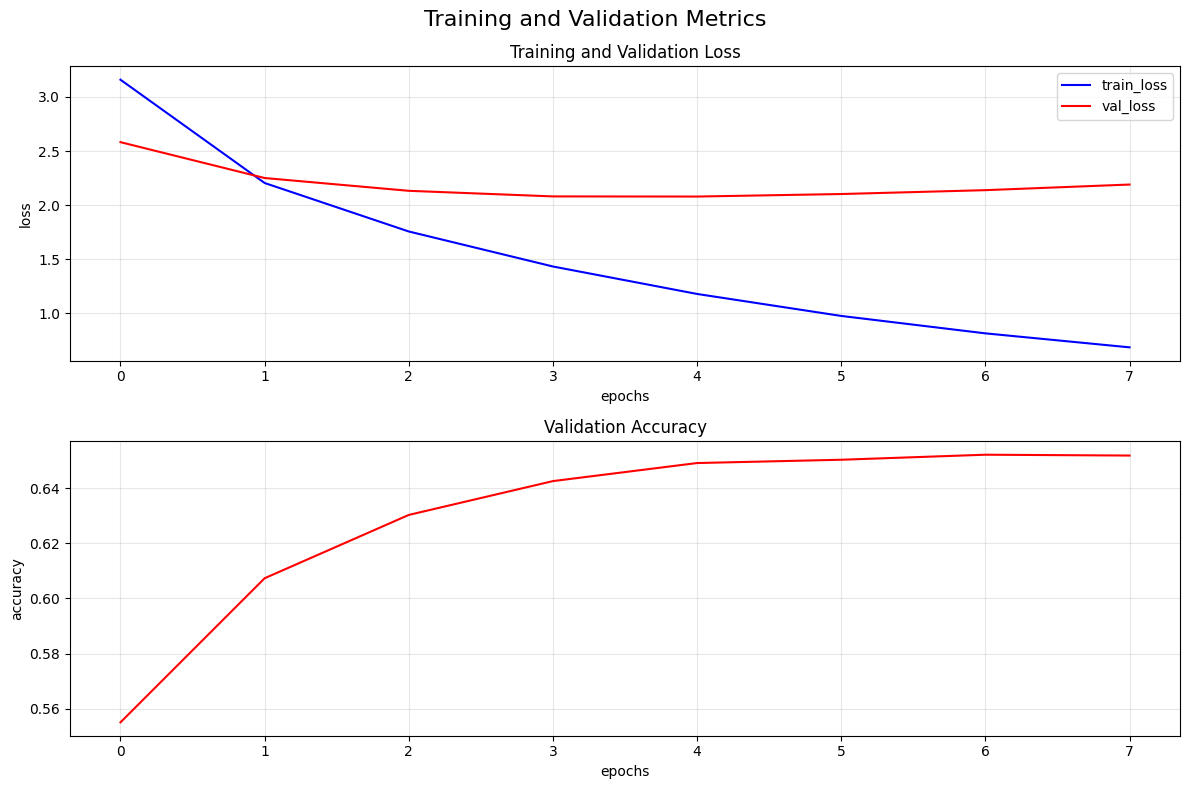

In [25]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(
    train_val_metrics["epoch"],
    train_val_metrics["train_loss"],
    color="blue",
    label="train_loss",
)
ax1.plot(
    train_val_metrics["epoch"],
    train_val_metrics["val_loss"],
    color="red",
    label="val_loss",
)
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.legend()
ax1.set_title("Training and Validation Loss")
ax1.grid(True, alpha=0.3)

ax2.plot(
    train_val_metrics["epoch"],
    train_val_metrics["val_acc"],
    color="red",
    label="val_loss",
)
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.set_title("Validation Accuracy")
ax2.grid(True, alpha=0.3)

fig.suptitle("Training and Validation Metrics", fontsize=16)
fig.tight_layout()


P.S. лучше использовать метрику `BLEU`.

### Перевод

In [26]:
class TranslationInference:
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        rus_tokenizer: Tokenizer,
        eng_tokenizer: Tokenizer,
        device: torch.device,
        max_translated_len: int = 30,
    ):
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.rus_tokenizer = rus_tokenizer
        self.eng_tokenizer = eng_tokenizer
        self.device = device
        self.max_translated_len = max_translated_len

    @torch.inference_mode()
    def greedy_decode(self, sentence: str) -> str:
        encoder_input = (
            torch.tensor(self.rus_tokenizer.encode(sentence).ids)
            .unsqueeze(0)
            .to(self.device)
        )

        _, hidden_state = self.encoder(
            encoder_input,
            torch.tensor([encoder_input.size(-1)], dtype=torch.long),
        )

        current_word_id = (
            torch.tensor(
                [self.eng_tokenizer.token_to_id("[BOS]")], dtype=torch.long
            )
            .unsqueeze(0)
            .to(self.device)
        )  # (1, 1)
        decoded_sentence_ids = []
        one = torch.tensor([1], dtype=torch.long)
        while len(decoded_sentence_ids) < self.max_translated_len:
            logits, hidden_state = self.decoder(
                current_word_id, one, hidden_state
            )

            # logits: (batch_size, seq_len, vocab_size)
            # то есть: (1, 1, vocab_size)
            current_word_id = torch.argmax(logits, dim=-1)
            decoded_sentence_ids.append(current_word_id.cpu().item())
            if decoded_sentence_ids[-1] == self.eng_tokenizer.token_to_id(
                "[EOS]"
            ):
                break

        return self.eng_tokenizer.decode(decoded_sentence_ids[:-1])

    @torch.inference_mode
    def test_sentences(
        self, rus_sentences: list[str], eng_sentences: list[str]
    ) -> pd.DataFrame:
        temp_dict = {
            "Rus Original": [],
            "Rus Tokenized": [],
            "Eng Original": [],
            "Eng Translation": [],
        }

        for rus_sentence, eng_sentence in tqdm(
            zip(rus_sentences, eng_sentences), desc="Translating"
        ):
            temp_dict["Rus Original"].append(rus_sentence)
            tokenized_rus = self.rus_tokenizer.encode(rus_sentence).tokens
            temp_dict["Rus Tokenized"].append(tokenized_rus)
            temp_dict["Eng Original"].append(eng_sentence)
            translated = self.greedy_decode(rus_sentence)
            temp_dict["Eng Translation"].append(translated)

        return pd.DataFrame(temp_dict)

In [27]:
inference = TranslationInference(
    lit_model.model.encoder,
    lit_model.model.decoder,
    rus_tokenizer,
    eng_tokenizer,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)

In [28]:
df = inference.test_sentences(
    test_rus_sentences[:100], test_eng_sentences[:100]
)

Translating: 100it [00:00, 172.43it/s]


In [29]:
df.head(20)

,Rus Original,Rus Tokenized,Eng Original,Eng Translation
0,Том вчера не был у меня дома.,"[[BOS], том, вчера, не, был, у, меня, дома, .,...",Tom wasn't at my house yesterday.,tom wasn ' t my parents at me .
1,Кто-нибудь из твоих друзей рисует?,"[[BOS], кто, -, нибудь, из, твоих, друзей, ри...",Do any of your friends paint?,will you live with my parents ?
2,Поверх пижамы он носил халат.,"[[BOS], поверх, [UNK], он, носил, [UNK], ., [E...",He wore a robe over his pajamas.,the prisoner was accused of his fingers .
3,Том расстроен.,"[[BOS], том, расстроен, ., [EOS]]",Tom's upset.,tom is upset .
4,"Том вёл себя, словно безумец.","[[BOS], том, вёл, себя, ,, словно, [UNK], ., ...",Tom acted like a madman.,tom hid himself he was a spy .
5,"Давайте посмотрим, что происходит снаружи.","[[BOS], давайте, посмотрим, ,, что, происходи...",Let's see what's happening outside.,let ' s pretend that you ' ll be glad .
6,Он открыл дверцу автомобиля.,"[[BOS], он, открыл, дверцу, автомобиля, ., [EOS]]",He opened the door of the car.,he opened the window .
7,Том знает почему.,"[[BOS], том, знает, почему, ., [EOS]]",Tom knows why.,tom knows why .
8,Том готовился.,"[[BOS], том, готовился, ., [EOS]]",Tom was getting ready.,tom ' s a tomcat .
9,Он ходит в школу для глухих.,"[[BOS], он, ходит, в, школу, для, глухих, ., [...",He goes to a school for the deaf.,he goes to a tennis with a game .


### Вывод

- Подход рабочий. Есть предложения, которая модель переводит даже точь-в-точь.
- Но большинство предложений все таки переведены неправильно, хотя связь все же можно проследить.
- Мы используем небольшую обучающую выборку. Для создания чего-то более надежного требуется гораздо больше данных.
- Мы используем только легкую однослойную LSTM архитектуру. Когда Google Translate был основан на рекуррентности, он использовал восьмислойный LSTM.


## Машинный перевод seq2seq with attention

Модель будет использовать два LSTM сети (энкодер и декодер) и слой attention для перевода с русского языка на английский.


### Модель

Перепишу определение сетей, чтобы все было на одном месте.

In [30]:
class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        padding_idx: int,
        hidden_size: int,
    ):
        super().__init__()
        self.padding_idx = padding_idx
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=padding_idx
        )
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True,
        )

    def forward(self, inputs, lengths):
        # encoder_inputs: (batch_size, seq_len)
        embeddings = self.embedding(inputs)

        embeddings = pack_padded_sequence(
            embeddings,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False,
        )
        y, hidden_state = self.lstm(embeddings)

        # y: (batch_size, seq_len, hidden_size)
        # the hidden state consists of
        # h_t: (num_layers, batch_size, hidden_size)
        # c_t: (num_layers, batch_size, hidden_size)
        y, _ = pad_packed_sequence(
            y, batch_first=True, padding_value=self.padding_idx
        )
        return y, hidden_state


class LuongAttention(nn.Module):
    def __init__(self, hidden_size: int):
        # В нашем случае encoder_hidden_size = decoder_hidden_size
        super().__init__()
        self.hidden_size = hidden_size
        self.w = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(
        self,
        encoder_outputs: torch.Tensor,  # (batch, en_seq_len, hidden_size)
        decoder_outputs: torch.Tensor,  # (batch, de_seq_len, hidden_size)
        encoder_mask: torch.Tensor,  # (batch, en_seq_len) -> 1 for valid, 0 for padding
    ):
        # encoder_outputs: (batch_size, en_seq_len, hidden_size)
        # decoder_outputs: (batch_size, de_seq_len, hidden_size)
        encoder_transformed = self.w(encoder_outputs)
        # encoder_transformed: (batch_size, en_seq_len, hidden_size)

        scores = torch.bmm(
            decoder_outputs, encoder_transformed.transpose(1, 2)
        )
        # scores: (batch_size, de_seq_len, en_seq_len)
        scores = scores.masked_fill(~encoder_mask.unsqueeze(1), float("-inf"))

        attention_weights = torch.softmax(scores, dim=-1)
        # attention_weights: (batch_size, de_seq_len, en_seq_len)

        context_vector = torch.bmm(attention_weights, encoder_outputs)
        # context_vector: (batch_size, de_seq_len, hidden_size)

        return context_vector, attention_weights


class DecoderWithAttention(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        padding_idx: int,
        hidden_size: int,
    ):
        super().__init__()
        self.padding_idx = padding_idx
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=padding_idx
        )
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.attention = LuongAttention(hidden_size)

        # комбинируем [lstm_output ; context_vector]
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size), nn.Tanh()
        )
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(
        self,
        decoder_inputs,  # (batch, de_seq_len)
        decoder_lengths,  # (batch,)
        encoder_outputs,  # (batch, en_seq_len, hidden_size)
        encoder_hidden_state,  # (h_0, c_0) из энкодера
        encoder_mask,  # (batch, en_seq_len)
    ):
        # 1. Эмбеддинг
        embeddings = self.embedding(decoder_inputs)
        embeddings = pack_padded_sequence(
            embeddings,
            decoder_lengths.cpu(),
            batch_first=True,
            enforce_sorted=False,
        )

        # 2. Прогон через LSTM (инициализируем скрытое состоянием энкодера)
        packed_out, hidden_state = self.lstm(embeddings, encoder_hidden_state)

        # 3. Делаем unpack для внимания
        decoder_outputs, _ = pad_packed_sequence(
            packed_out, batch_first=True, padding_value=self.padding_idx
        )
        # decoder_outputs: (batch, de_seq_len, hidden_size)

        # 4. Вычисляем внимание (Luong)
        context_vector, attention_weights = self.attention(
            encoder_outputs, decoder_outputs, encoder_mask
        )
        # context_vector: (batch, de_seq_len, hidden_size)

        # 5. Конкатенируем выходы декодера и контекст
        combined = torch.cat([decoder_outputs, context_vector], dim=-1)
        combined = self.fc(combined)
        # combined: (batch, de_seq_len, hidden_size)

        # 6. Предсказание токенов
        logits = self.out(combined)  # (batch, de_seq_len, vocab_size)

        return logits, hidden_state, attention_weights


class TranslationModel(nn.Module):
    def __init__(self, encoder: Encoder, decoder: DecoderWithAttention):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.padding_idx = encoder.embedding.padding_idx

    def forward(
        self,
        encoder_inputs,  # (batch, en_seq_len)
        encoder_inputs_lengths,  # (batch,)
        decoder_inputs,  # (batch, de_seq_len)
        decoder_inputs_lengths,  # (batch,)
    ):
        # 1. Прогон через энкодер
        encoder_outputs, encoder_hidden_state = self.encoder(
            encoder_inputs, encoder_inputs_lengths
        )
        # encoder_outputs: (batch, en_seq_len, hidden_size)
        # encoder_hidden_state: (h, c)

        encoder_mask = encoder_inputs != self.padding_idx
        # 2. Прогон через декодер с вниманием
        decoder_logits, decoder_hidden_state, attention_weights = self.decoder(
            decoder_inputs,
            decoder_inputs_lengths,
            encoder_outputs,
            encoder_hidden_state,
            encoder_mask,
        )

        # decoder_logits: (batch, de_seq_len, vocab_size)
        # attention_weights: (batch, de_seq_len, en_seq_len)

        return decoder_logits, decoder_hidden_state, attention_weights

### Обучение модели

In [31]:
class LitTranslationModel(pl.LightningModule):
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        pad_idx: int,
        vocab_size: int,
        lr: float = 1e-3,
    ):
        super().__init__()
        self.model = TranslationModel(encoder, decoder)
        self.pad_idx = pad_idx
        self.lr = lr

        # loss
        self.criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

        # accuracy (символьная точность)
        self.val_accuracy = MulticlassAccuracy(
            num_classes=vocab_size, ignore_index=pad_idx, average="micro"
        )
        self.test_accuracy = MulticlassAccuracy(
            num_classes=vocab_size, ignore_index=pad_idx, average="micro"
        )

    def forward(self, batch):
        (
            encoder_inputs,
            encoder_inputs_lengths,
            decoder_inputs,
            decoder_inputs_lengths,
            decoder_targets,
        ) = batch

        logits, hidden_state, attention_weights = self.model(
            encoder_inputs,
            encoder_inputs_lengths,
            decoder_inputs,
            decoder_inputs_lengths,
        )
        return logits, hidden_state, attention_weights, decoder_targets

    def _step(self, batch, stage: str):
        logits, hidden_state, attention_weights, targets = self.forward(batch)

        loss = self.criterion(
            logits.permute(0, 2, 1),  # (batch, vocab, seq_len)
            targets,
        )

        # accuracy только для val/test
        if stage == "val":
            preds = torch.argmax(logits, dim=-1)
            acc = self.val_accuracy(preds, targets)
            self.log(
                "val_acc", acc, prog_bar=True, on_epoch=True, on_step=False
            )

        if stage == "test":
            preds = torch.argmax(logits, dim=-1)
            acc = self.test_accuracy(preds, targets)
            self.log(
                "test_acc", acc, prog_bar=True, on_epoch=True, on_step=False
            )

        self.log(
            f"{stage}_loss", loss, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._step(batch, "test")

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)


In [32]:
embedding_dim = 128
hidden_size = 256
batch_size = 32
dropout = 0.2
epochs = 30

encoder = Encoder(
    vocab_size=len(rus_tokenizer.get_vocab()),
    embedding_dim=embedding_dim,
    padding_idx=rus_tokenizer.token_to_id("[PAD]"),
    hidden_size=hidden_size,
)

decoder = DecoderWithAttention(
    vocab_size=len(eng_tokenizer.get_vocab()),
    embedding_dim=embedding_dim,
    padding_idx=eng_tokenizer.token_to_id("[PAD]"),
    hidden_size=hidden_size,
)

lit_model = LitTranslationModel(
    encoder=encoder,
    decoder=decoder,
    pad_idx=eng_tokenizer.token_to_id("[PAD]"),
    vocab_size=len(eng_tokenizer.get_vocab()),
    lr=1e-3,
)

LOGS_DIR = "08.translation/attention/"

# --- callbacks ---
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=3,  # если 3 эпохи подряд нет улучшений -> стоп
    mode="min",
)

# сохраняем лучшую модель
checkpoint_best = ModelCheckpoint(
    monitor="val_loss",
    dirpath=LOGS_DIR + "checkpoints/",
    filename="best-model-{epoch}",
    save_top_k=1,
    mode="min",
)

# чекпоинт каждые 3 эпохи (перезаписывает один файл)
checkpoint_periodic = ModelCheckpoint(
    dirpath=LOGS_DIR + "checkpoints/",
    filename="{epoch}",
    save_top_k=1,
    every_n_epochs=3,
    save_last=False,
)

progress_bar = TQDMProgressBar(leave=True)

csv_logger = CSVLogger(save_dir=LOGS_DIR)

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        early_stop_callback,
        checkpoint_best,
        checkpoint_periodic,
        progress_bar,
    ],
    logger=csv_logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [33]:
ckpt_path = LOGS_DIR + "checkpoints/best-model-epoch=3.ckpt"
if os.path.exists(ckpt_path):
    # нужно было делать save_hyperparameters(ignore=...)
    lit_model = LitTranslationModel.load_from_checkpoint(
        ckpt_path,
        encoder=encoder,
        decoder=decoder,
        pad_idx=eng_tokenizer.token_to_id("[PAD]"),
        vocab_size=len(eng_tokenizer.get_vocab()),
        lr=1e-3,
    )
else:
    disable_tokenizers_parallelism()
    trainer.fit(lit_model, train_dataloader, val_dataloader)
    enable_tokenizers_parallelism()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | TranslationModel   | 9.7 M  | train
1 | criterion     | CrossEntropyLoss   | 0      | train
2 | val_accuracy  | MulticlassAccuracy | 0      | train
3 | test_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
9.7 M     Trainable params
0         Non-trainable params
9.7 M     Total params
38.818    Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 6: 100%|██████████| 4375/4375 [01:19<00:00, 55.30it/s, v_num=0, val_acc=0.650, val_loss=2.180, train_loss=0.799]


In [34]:
ckpt_path = LOGS_DIR + "checkpoints/best-model-epoch=3.ckpt"
if os.path.exists(ckpt_path):
    # нужно было делать save_hyperparameters(ignore=...)
    lit_model = LitTranslationModel.load_from_checkpoint(
        ckpt_path,
        encoder=encoder,
        decoder=decoder,
        pad_idx=eng_tokenizer.token_to_id("[PAD]"),
        vocab_size=len(eng_tokenizer.get_vocab()),
        lr=1e-3,
    )

In [35]:
results = pd.read_csv(LOGS_DIR + "lightning_logs/version_0/metrics.csv").drop(
    "step", axis=1
)

In [36]:
train_val_metrics = results.groupby("epoch").last().reset_index()

In [37]:
train_val_metrics

,epoch,train_loss,val_acc,val_loss
0,0,3.180278,0.551145,2.598531
1,1,2.250264,0.604210,2.254827
2,2,1.802257,0.629822,2.112185
3,3,1.467007,0.643021,2.064857
4,4,1.197496,0.649942,2.072218
5,5,0.975804,0.651210,2.111032
6,6,0.798734,0.650463,2.177527


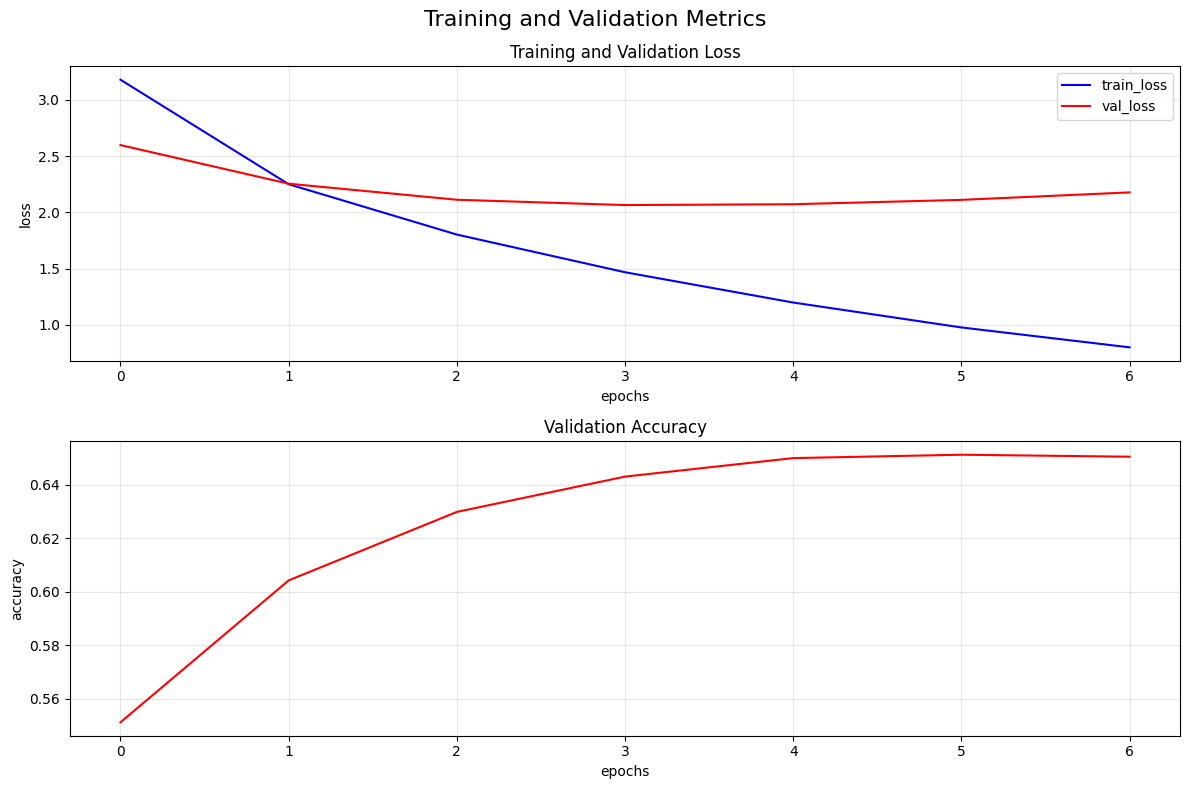

In [38]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(
    train_val_metrics["epoch"],
    train_val_metrics["train_loss"],
    color="blue",
    label="train_loss",
)
ax1.plot(
    train_val_metrics["epoch"],
    train_val_metrics["val_loss"],
    color="red",
    label="val_loss",
)
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.legend()
ax1.set_title("Training and Validation Loss")
ax1.grid(True, alpha=0.3)

ax2.plot(
    train_val_metrics["epoch"],
    train_val_metrics["val_acc"],
    color="red",
    label="val_loss",
)
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.set_title("Validation Accuracy")
ax2.grid(True, alpha=0.3)

fig.suptitle("Training and Validation Metrics", fontsize=16)
fig.tight_layout()


### Перевод

In [39]:
class TranslationWithAttentionInference(TranslationInference):
    def __init__(
        self,
        encoder: Encoder,
        decoder: DecoderWithAttention,
        rus_tokenizer: Tokenizer,
        eng_tokenizer: Tokenizer,
        device: torch.device,
        max_translated_len: int = 30,
    ):
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.rus_tokenizer = rus_tokenizer
        self.eng_tokenizer = eng_tokenizer
        self.device = device
        self.max_translated_len = max_translated_len

    @torch.inference_mode()
    def greedy_decode(self, sentence: str) -> str:
        encoder_input = (
            torch.tensor(self.rus_tokenizer.encode(sentence).ids)
            .unsqueeze(0)
            .to(self.device)
        )

        mask = torch.ones_like(encoder_input).bool()

        encoder_outputs, hidden_state = self.encoder(
            encoder_input,
            torch.tensor([encoder_input.size(-1)], dtype=torch.long),
        )

        current_word_id = (
            torch.tensor(
                [self.eng_tokenizer.token_to_id("[BOS]")], dtype=torch.long
            )
            .unsqueeze(0)
            .to(self.device)
        )  # (1, 1)
        decoded_sentence_ids = []
        one = torch.tensor([1], dtype=torch.long)
        while len(decoded_sentence_ids) < self.max_translated_len:
            logits, hidden_state, attention_weights = self.decoder(
                current_word_id, one, encoder_outputs, hidden_state, mask
            )

            # logits: (batch_size, seq_len, vocab_size)
            # то есть: (1, 1, vocab_size)
            current_word_id = torch.argmax(logits, dim=-1)
            decoded_sentence_ids.append(current_word_id.cpu().item())
            if decoded_sentence_ids[-1] == self.eng_tokenizer.token_to_id(
                "[EOS]"
            ):
                break

        return self.eng_tokenizer.decode(decoded_sentence_ids[:-1])

In [40]:
inference = TranslationWithAttentionInference(
    lit_model.model.encoder,
    lit_model.model.decoder,
    rus_tokenizer,
    eng_tokenizer,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)

In [41]:
df_attention = inference.test_sentences(
    test_rus_sentences[:100], test_eng_sentences[:100]
)

Translating: 100it [00:00, 135.33it/s]


In [42]:
df_attention.head(20)

,Rus Original,Rus Tokenized,Eng Original,Eng Translation
0,Том вчера не был у меня дома.,"[[BOS], том, вчера, не, был, у, меня, дома, .,...",Tom wasn't at my house yesterday.,tom didn ' t have my phone at home .
1,Кто-нибудь из твоих друзей рисует?,"[[BOS], кто, -, нибудь, из, твоих, друзей, ри...",Do any of your friends paint?,has anybody asked us from you ?
2,Поверх пижамы он носил халат.,"[[BOS], поверх, [UNK], он, носил, [UNK], ., [E...",He wore a robe over his pajamas.,he put the alarm of the red t .
3,Том расстроен.,"[[BOS], том, расстроен, ., [EOS]]",Tom's upset.,tom is upset .
4,"Том вёл себя, словно безумец.","[[BOS], том, вёл, себя, ,, словно, [UNK], ., ...",Tom acted like a madman.,tom behaved being interested .
5,"Давайте посмотрим, что происходит снаружи.","[[BOS], давайте, посмотрим, ,, что, происходи...",Let's see what's happening outside.,let ' s pretend that ' s happening on the way .
6,Он открыл дверцу автомобиля.,"[[BOS], он, открыл, дверцу, автомобиля, ., [EOS]]",He opened the door of the car.,he opened the windows .
7,Том знает почему.,"[[BOS], том, знает, почему, ., [EOS]]",Tom knows why.,tom knows why .
8,Том готовился.,"[[BOS], том, готовился, ., [EOS]]",Tom was getting ready.,tom is going to be punished .
9,Он ходит в школу для глухих.,"[[BOS], он, ходит, в, школу, для, глухих, ., [...",He goes to a school for the deaf.,he goes to school for school .


### Вывод

- Модель с механизмом внимания переводит предложения гораздо лучше.
- Для повышения качества перевода можно реализовать `Beam Search`.